# Load modules

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from FNORUNet_5layer_model import *
from analysis_new_utils import *

# Initialize helper functions

In [20]:
def processPermMap(permMap):
    # first 6 elements are 6 repeats of the radial permeability map, k_r
    # second 6 elements are 6 repeats of the vertical permeability map, k_z
    # isotropic case: k_r = k_z so first 12 elements are identical
    newPermMap = np.zeros((24, 96, 200))
    # ALL SANDSTONE
#     perm_map = np.ones((96, 27826)) * 100
    
    for j in range(6):
        newPermMap[j, :, :] = permMap
        
    for j in range(6):
        newPermMap[j+6, :, :] = permMap
        
    # make it anisotropic - increase anisotropy ratio a lot, so k_z will decrease
    # e.g. anisotropy ratio of 100 means that if k_r = 2000, k_z = 20mD
    # set it to the maximum ratio in the model (100?)
    
    # third 6 elements are 6 repeats of the porosity map = average of k_r and k_z + gaussian noise
    porosityMap = generate_porosity_map(permMap, permMap) # isotropic case: k_r = k_z
    for j in range(6):
        newPermMap[j+12, :, :] = porosityMap
        
    # fourth 6 elements are fixed parameters 
    # values taken from data_x_shale[0, :, 0, 0] of shale_clean.hdf5
    newPermMap[-1,:,:] = 0.67188413 # cap pressure scaling factor
    newPermMap[-2,:,:] = 0.7477531  # irreducible water saturation
    newPermMap[-3,:,:] = 0.55994362 # temp
    newPermMap[-4,:,:] = 0.56070183 # pressure
    newPermMap[-5,:,:] = 0.75278992 # injection rate
    newPermMap[-6,95:,0] = 1 # injection location: 1 = yes inject, 0 = no inject.
    # here, inject at 190-200m in reservoir (scaled to 96 grid)
            
    # normalize k_r and k_z
    newPermMap[0:12, :, :] = np.log(newPermMap[0:12, :, :])/15
    
    return newPermMap

In [3]:
def preparePermMaps(data_x_shale):

    data_x = np.concatenate([data_x_shale], axis=0)

    data_nr = data_x.shape[0]

    # np.random.seed(0)
    # shuffle_index = np.random.choice(data_nr, data_nr, replace=False)
    # print(shuffle_index.shape)

    # data_x = data_x[shuffle_index, ...]

    idx = [0,6,12,18,19,20,21,22,23]
    data_x_fit = np.zeros((data_x.shape[0], len(idx)+3, 96, 200))
    for j, index in enumerate(idx):
        data_x_fit[:,j,:,:] = data_x[:,index,:,:]

    dz = 2.083330
    dx = [0.1]

    with open('DRV.txt') as f:
        for line in f:
            line = line.strip().split('*')
            dx.append(float(line[-1]))
    dx = np.cumsum(dx)
    grid_x = dx/np.max(dx)
    grid_x = grid_x[1:]
    grid_y = np.linspace(0, 200, 96)/np.max(dx)

    data_x_fit[:,-3,:,:] = grid_x[np.newaxis, np.newaxis, :]
    data_x_fit[:,-2,:,:] = grid_y[np.newaxis, :, np.newaxis]
    data_x_fit[:,-1,:,:] = np.ones(data_x_fit[:,-1,:,:].shape)

    data_x_fit[:,-3,:,:] = data_x_fit[:,-3,:,:]/np.max(data_x_fit[:,-3,:,:])
    data_x_fit[:,-2,:,:] = data_x_fit[:,-2,:,:]/np.max(data_x_fit[:,-2,:,:])

    x_in = data_x_fit.transpose((0,2,3,1))

    x_in = x_in.astype(np.float32)

    x_in = torch.from_numpy(x_in)
    print(x_in.shape)

    # a input u output
    T = 24

    x_in = x_in[:,:,:,np.newaxis,:]
    print(x_in.shape)

    x_in = x_in.repeat([1,1,1,T,1])
    print(x_in.shape)

    t = np.cumsum(np.power(1.421245, range(24)))
    t /= np.max(t)
    for i in range(24):
        x_in[:,:,:,i,-1] = t[i]
        
    return x_in

# Plot result of Sleipner-like prediction

torch.Size([1, 96, 200, 12])
torch.Size([1, 96, 200, 1, 12])
torch.Size([1, 96, 200, 24, 12])


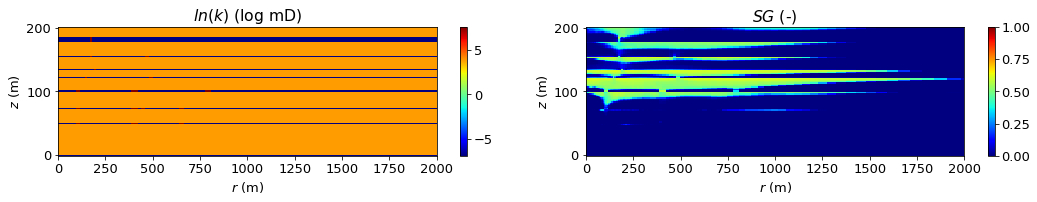

In [23]:
dx = np.cumsum(3.5938*np.power(1.035012, range(200))) + 0.1

res = np.ones((96, 200)) * 50 # permeability (mD)

# ASSUMPTIONS
# 1. The modeled reservoir corresponds to 800m-1000m depth in the RESCUE model
# 2. "There are nine sandstone layers in the model, named Utsira L1 (lowermost) to Utsira L9 (uppermost)."
# [except we do not simulate L9 since it is >200m depth]
# 3. "Layers L1 to L8 are vertically separated by thin, low-permeability shale layers ("intrashales") 
# that constitute laterally continuous zones about 1 m thick."
# 4. "Layer L8 and L9 are separated by a thicker layer of shale (approx. 7 m)"
# 5. Caprock is immediately above the simulated reservoir
# 6. Lowermost L1-L2 shale layer is immediately below the simulated reservoir (approx. 207m depth)
# 7. Location of shale layers are approximated as the average of the depth of the shale layer at each end of the reservoir

def y(n):
    return np.rint(n * 96/200).astype('int')

def x(n):
    return (np.abs(dx - n)).argmin()
# resx = 109 # index in re-gridded x-axis closest to <4500m (length of sleipner model). dx[106] = 3975m
resx = 200 # across entire reservoir 

# ADD SHALE LAYERS
sh = 0.001 # shale permeability (mD)
res[y(15):y(22), :resx] = sh # 7m L8-L9 shale layer
res[y(43), :resx] = sh # 1m L7-L8 shale layer
res[y(65), :resx] = sh # 1m L6-L7 shale layer
res[y(78), :resx] = sh # 1m L5-L6 shale layer
res[y(98), :resx] = sh # 1m L4-L5 shale layer
res[y(125), :resx] = sh # 1m L3-L4 shale layer
res[y(148), :resx] = sh # 1m L2-L3 shale layer
res[y(200)-1, :resx] = sh # 1m L1-L2 shale layer

# ADD APERTURES
ap = 2000 # aperture permeability (mD)
res[y(15):y(22), x(180):x(182)] = ap
res[y(43), x(180):x(185)] = ap
res[y(43), x(380):x(385)] = ap
res[y(43), x(480):x(485)] = ap
res[y(43), x(550):x(555)] = ap
res[y(65), x(200):x(205)] = ap
res[y(65), x(400):x(405)] = ap
res[y(65), x(490):x(495)] = ap
res[y(78), x(150):x(155)] = ap
res[y(78), x(380):x(385)] = ap
res[y(78), x(500):x(505)] = ap
res[y(98), x(100):x(125)] = ap
res[y(98), x(400):x(425)] = ap
res[y(98), x(800):x(825)] = ap
res[y(125), x(100):x(125)] = ap
res[y(125), x(400):x(425)] = ap
res[y(125), x(450):x(475)] = ap
res[y(125), x(650):x(675)] = ap
res[y(148), x(100):x(125)] = ap
res[y(148), x(400):x(425)] = ap
res[y(148), x(650):x(675)] = ap

# res[:, resx:] = sh # blocking off rest of reservoir since only <4500m long

# PLOT
data = np.zeros((1, 24, 96, 200))
data[0, :, :, :] = processPermMap(res)

dx = np.cumsum(3.5938*np.power(1.035012, range(200))) + 0.1
X, Y = np.meshgrid(dx, np.linspace(0,200,num = 96))

def pcolor(x):
    plt.jet()
    return plt.pcolor(X[:thickness, :200], Y[:thickness, :200], np.flipud(x), shading='auto')

# SG model
modelname = '/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_199ep_32width_12m1_12m2_12m3_3000train_200eps_l2err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_5layer'
model = torch.load(modelname, map_location=torch.device('cuda:0'))
device = torch.device('cuda:0')
# model = torch.load(modelname, map_location=torch.device('cpu'))
# device = torch.device('cpu')

x_in = preparePermMaps(data)
eval_loader = torch.utils.data.DataLoader(x_in, batch_size=1, shuffle=False)

# normalization constants
SG_mean = 0.019367479650039064
SG_std = 0.10341674964334545


plt.rcParams.update({'font.size':13})


t0 = default_timer()
with torch.no_grad():
    for x in eval_loader:
        x = x.to(device)
        pred = model(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        pred_plot = pred.cpu().detach().numpy()
        pred_plot = pred_plot*SG_std + SG_mean
        
        mask = x_plot[0,:,:,0,0] != 0
        fullmask = x_plot[0, :, :, :, 0] != 0
        
        thickness = sum(mask[:,0])
        
        sleipner = plt.figure(figsize=(15, 3))
        plt.subplot(1, 2, 1)
        pcolor(np.log(np.exp(x_plot[0,:,:,0,0][mask].reshape((thickness, -1))*15)))
        plt.xlim([0, 2000])
        plt.jet()
        plt.colorbar()
#         plt.clim([0, 100])
        plt.title('$ln(k)$ (log mD)')
        plt.xlabel('$r$ (m)')
        plt.ylabel('$z$ (m)')
        
        plt.subplot(1, 2, 2)
        pcolor(pred_plot[0,:,:,-3][mask].reshape((thickness, -1)))
        # t = -3 is 14.8 years
        plt.xlim([0, 2000])
        plt.jet()
        plt.colorbar()
        plt.clim([0, 1])
        plt.title('$SG$ (-)')
        plt.xlabel('$r$ (m)')
        plt.ylabel('$z$ (m)')
        plt.tight_layout()
        plt.show()
        
# sleipner.savefig('sleipnerSim_220725.png', dpi=300)